### Human activity recognition.
The dataset: <http://archive.ics.uci.edu/ml/datasets/Activity+Recognition+from+Single+Chest-Mounted+Accelerometer#>

In [5]:
%matplotlib inline
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from datetime import datetime, timedelta
import warnings

warnings.filterwarnings('ignore')

# the function assumes the data is in Activity_Recognition folder
def read_data(fname='all'):
    freq = '19230U'   # ~19ms, using sampling frequency is 52samples/sec
    dt = datetime.now()
    data = pd.DataFrame()
    
    if fname == 'all':    # read all files
        data_files = []
        
        for f_id in range(1,16):
            data = pd.read_csv('Activity_Recognition/%d.csv' %f_id, 
                               names=['id', 'x', 'y', 'z', 'label'], 
                               header=None, index_col=0)
            data.index = pd.date_range(start=dt, periods=data.shape[0], freq=freq)
            dt += timedelta(hours=3)
            data_files.append(data)
            
        data = pd.concat(data_files)
    
    else:    # read one file only
        data = pd.read_csv('Activity_Recognition/%s.csv' %fname, 
                   names=['id', 'x', 'y', 'z', 'label'], 
                   header=None, index_col=0)

        data.index = pd.date_range(start='00:00:00', periods=data.shape[0], freq=freq)
        
    # Filter and clean data
    data = data.dropna()
    data = data[data['label'] != 0]   # some rows are misclassified as 0
        
    return data

### Feature extraction.
Segment the data using sliding window of size 10s, and from each window extract the common features (mean, standard deviation, variance), and some other features used specifically for Human Activity Recognition like RMS (Root Mean Square), magnitude of acceleration, and pairwise correlation between x, y, z.

In [2]:
from scipy.stats import mode 


def rms(ts): return np.sqrt(np.mean(ts**2))

def corr(df): 
    cor = df.corr()
    return pd.DataFrame({'xy':[cor['x']['y']], 'xz':[cor['x']['z']], 'yz':[cor['y']['z']]})

def get_features(data, wsize='10s', f_list=['mean', 'std', 'var', rms]):
    # f_list is a list of features names or methods to apply in resampling
    
    # features that invlove one dimension only.
    fname = '_' + (f_list[0] if isinstance(f_list[0], str) else f_list[0].__name__)   
    feats = data[['x','y','z']].resample(wsize, how=f_list[0]).add_suffix(fname)
    
    for i, f in enumerate(f_list[1:]):
        fname = '_' + (f if isinstance(f, str) else f.__name__)
        feat = data[['x','y','z']].resample(wsize, how=f).add_suffix(fname)
        feats = feats.join(feat)   

    # features that involve more than one dimension.                                               
    mean_mag = (data**2).sum(axis=1).resample(wsize, how=lambda ts: np.sqrt(ts).mean())
    mean_mag.name = 'mean_mag'
    feats = feats.join(mean_mag) 

    pairs_cor = data.groupby(pd.TimeGrouper(wsize)).apply(corr).reset_index(1, drop=True)
    feats = feats.join(pairs_cor) 
    
    y = data['label'].resample(wsize, how=lambda ts: mode(ts)[0] if ts.shape[0] > 0 else np.nan)   

    # drop any nan values
    mask = np.any(np.isnan(feats), axis=1)
    feats, y = feats[~mask], y[~mask]
    mask = np.isnan(y)
    feats, y = feats[~mask], y[~mask]
    
    return (feats, y)


### Choosing and tuning the model.

Splitting data (after feature extraction) into train and test subsets. Using grid search on the training set each model is trained and tuned, then the models are compared according to their performance on the test set using accuracy and AUC (Area Under ROC Curve). The best accuracy result of .899 for SVM and RandomForest, and best AUC result of .99 for RandomForest.

    Activity codes in confusion matrix:
    1: Working at Computer
    2: Standing Up, Walking and Going up\down stairs
    3: Standing
    4: Walking
    5: Going Up\Down Stairs
    6: Walking and Talking with Someone
    7: Talking while Standing
    

Support Vector Machine
Accuracy score on the test set: 0.899
Confusion Matrix...
    1  2  3   4  5  6   7
1  15  0  0   0  0  1   0
2   0  0  1   0  0  0   0
3   0  0  1   0  0  0   4
4   0  0  0  12  0  0   1
5   0  0  0   0  2  0   0
6   0  0  0   1  0  0   0
7   0  0  0   0  0  0  41
Random Forest
Accuracy score on the test set: 0.899
Confusion Matrix...
    1  2  3   4  5  6   7
1  15  0  0   0  1  0   0
2   0  0  0   0  0  0   1
3   0  0  0   0  0  0   5
4   0  0  0  13  0  0   0
5   0  0  0   0  2  0   0
6   0  0  0   1  0  0   0
7   0  0  0   0  0  0  41
Gradient Boosting
Accuracy score on the test set: 0.848
Confusion Matrix...
    1  2  3   4  5  6   7
1  15  0  0   0  1  0   0
2   1  0  0   0  0  0   0
3   0  0  0   0  0  0   5
4   0  0  0  12  0  0   1
5   0  0  0   0  2  0   0
6   0  0  0   1  0  0   0
7   0  0  3   0  0  0  38
Ada Boosting
Accuracy score on the test set: 0.873
Confusion Matrix...
    1  2  3   4  5  6   7
1  15  0  0   1  0  0   0
2   0  0  0   0  0  0   

(0.9464562303049725, 0.86075949367088611)

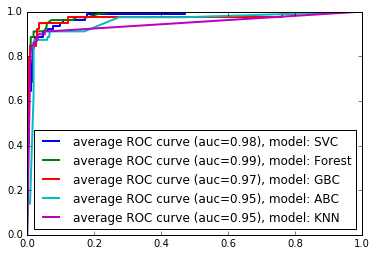

In [6]:
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier

def train_model(X, y, est, grid):
    gs = GridSearchCV(estimator=est, param_grid=grid, scoring='accuracy', cv=5, n_jobs=-1)
    gs = gs.fit(X, y)
    
    return (gs.best_estimator_, gs.best_params_)


def eval_model(mod, X_test, y_test, mod_name, plt_roc=True):
    y_prob = mod.predict_proba(X_test)
    y_test_bin = label_binarize(y_test, classes=[1, 2, 3, 4, 5, 6, 7])
    fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_prob.ravel())
    roc_auc = auc(fpr, tpr)
    
    if plt_roc:
        plt.plot(fpr, tpr, lw=2,
                 label='average ROC curve (auc=%0.2f), model: %s' % (roc_auc,mod_name))
        plt.legend(loc="lower right")
    
    y_pred = mod.predict(X_test)
    score = accuracy_score(y_true=y_test, y_pred=y_pred)
    print 'Accuracy score on the test set: %.3f' %score
    
    confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
    confmat = pd.DataFrame(confmat, index=list(range(1,8)), columns=list(range(1,8)))
    print 'Confusion Matrix...'
    print confmat
    
    return (roc_auc, score)


data = read_data('1')
param_range = [0.0001, 0.001, 0.01, 0.1]

feats, y = get_features(data, wsize='10s')
# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(feats, y, test_size=.25, random_state=0, stratify=y)


print 'Support Vector Machine'
model, params = train_model(X_train, y_train, 
                    est=SVC(probability=True),
                    grid={'C': param_range, 'gamma': param_range, 'kernel': ['linear']})
eval_model(model, X_test, y_test, 'SVC')
              


print 'Random Forest'
model, params = train_model(X_train, y_train, 
                    est=RandomForestClassifier(n_jobs=-1, criterion='entropy'),
                    grid={'n_estimators':[50, 100, 200]})
eval_model(model, X_test, y_test,'Forest')

print 'Gradient Boosting'
model, params = train_model(X_train, y_train, 
                    est=GradientBoostingClassifier(learning_rate=1.0, random_state=0),
                    grid={'n_estimators':[50, 200, 400], 'max_depth':[1,2,3],
                          'learning_rate':[.1,.05,.01,.005]})
eval_model(model, X_test, y_test,'GBC')

print 'Ada Boosting'
model, params = train_model(X_train, y_train, 
                    est=AdaBoostClassifier(),
                    grid={'n_estimators':[50, 200, 400], 'learning_rate':[.1,.05,.01,.005]})
eval_model(model, X_test, y_test,'ABC')

print 'K-Nearest Neighbor'
model, params = train_model(X_train, y_train, 
                    est=KNeighborsClassifier(),
                    grid={'n_neighbors':[5, 8, 10], 'weights':['uniform', 'distance']})
eval_model(model, X_test, y_test,'KNN')




### Trying different windows sizes.

The choice of a window size of 10sec was quite arbitrary. In the research papers on HAR different window sizes were used that range from 1 sec to 20 sec.
Also two types of windows are used in the field, disjoint and overlapping. get_features2 defines the same features defined before but using rolling window and taking only values at overlapping of 50%.
AUC scores are comparable, and the best accuracy score is .92 for overlapping-window of size 2sec.

In [12]:
def get_features2(data, wsize_sec, overlap=.5):
    wsize = 52 * wsize_sec   # sampling frequency/sec * length of window in seconds
    feats = pd.rolling_mean(data[['x','y','z']], wsize, wsize/2).add_suffix('_mean')
    
    feat = pd.rolling_std(data[['x','y','z']], wsize, wsize/2).add_suffix('_std')
    feats = feats.join(feat)
    
    feat = pd.rolling_var(data[['x','y','z']], wsize, wsize/2).add_suffix('_var')
    feats = feats.join(feat)
    
    feat = pd.rolling_apply(data[['x','y','z']], wsize, rms, wsize/2).add_suffix('_rms')
    feats = feats.join(feat)
        
    mean_mag = pd.rolling_apply((data**2).sum(axis=1), wsize, lambda ts: np.sqrt(ts).mean(), wsize/2)
    mean_mag.name = 'mean_mag'
    feats = feats.join(mean_mag) 

    xy_cor = pd.rolling_corr(data['x'], data['y'], wsize, wsize/2)
    xy_cor.name = 'xy'
    xz_cor = pd.rolling_corr(data['x'], data['z'], wsize, wsize/2)
    xz_cor.name = 'xz'
    yz_cor = pd.rolling_corr(data['y'], data['z'], wsize, wsize/2)
    yz_cor.name = 'yz'
    feats = feats.join(xy_cor).join(xz_cor).join(yz_cor)
    
    y = pd.rolling_apply(data['label'], wsize, lambda ts: mode(ts)[0], wsize/2)   
    # Take the values at the needed intersection point
    feats = feats.iloc[wsize*overlap::wsize*overlap] 
    y = y.iloc[wsize*overlap::wsize*overlap]
    
    return feats, y


win_sizes = ['2','3', '5', '7', '10', '13', '15', '20']
best_model = RandomForestClassifier(criterion='entropy', n_jobs=-1, n_estimators=50)

for wsize in win_sizes:
    print 'Window Size: %s sec' % wsize
    try:
        # disjoint window
        print 'Disjoint window:'
        feats, y = get_features(data, wsize=wsize + 's')
        X_train, X_test, y_train, y_test = train_test_split(feats, y, test_size=.25,
                                                            random_state=0, stratify=y)
        best_model.fit(X_train, y_train)
        roc_auc, acc = eval_model(best_model, X_test, y_test,'%ss - disjoint' %wsize, plt_roc=False)
        print 'AUC score: %.3f' % roc_auc


        # overlapping window
        print 'Overlapping window:'
        feats, y = get_features2(data, int(wsize))
        X_train, X_test, y_train, y_test = train_test_split(feats, y, test_size=.25,
                                                            random_state=0, stratify=y)
        best_model.fit(X_train, y_train)
        roc_auc, acc = eval_model(best_model, X_test, y_test,'%ss - overlapping' %wsize, plt_roc=False)
        print 'AUC score: %.3f' % roc_auc
    except Exception as e:
        print e

    

Window Size: 2 sec
Disjoint window:
Accuracy score on the test set: 0.913
Confusion Matrix...
    1  2   3   4  5  6    7
1  78  0   0   1  0  0    2
2   0  0   0   1  0  0    1
3   0  0  12   2  0  0   13
4   0  0   0  61  1  0    3
5   0  0   0   1  6  0    1
6   0  0   0   6  0  1    0
7   1  0   1   0  0  0  200
AUC score: 0.988
Overlapping window:
Accuracy score on the test set: 0.928
Confusion Matrix...
     1  2   3    4   5  6    7
1  162  0   0    0   0  0    0
2    0  0   0    0   0  0    4
3    0  0  23    5   1  0   25
4    0  0   1  124   4  0    0
5    0  0   0    0  13  0    2
6    0  0   1    6   2  3    2
7    1  0   1    1   0  0  399
AUC score: 0.993
Window Size: 3 sec
Disjoint window:
Accuracy score on the test set: 0.897
Confusion Matrix...
    1  2  3   4  5  6    7
1  54  0  0   0  0  0    0
2   1  0  0   1  0  0    0
3   0  0  3   1  0  0   14
4   0  0  0  39  1  3    0
5   0  0  0   0  3  0    2
6   0  0  1   3  0  1    0
7   0  0  0   0  0  0  135
AUC score: 0

### Testing model on the full dataset.

Accuracy score on the test set: 0.888
Confusion Matrix...
      1    2    3     4    5    6     7
1  2821   13   15    15    1    0    62
2    58  106   13    29    2    0    22
3    20    5  715   116   26   16   144
4    10    5   37  1639    6    1    18
5     8    0   40    35  131    4    29
6     4    1   16    41    4  100    64
7    46    1   53    26    7   24  2696


(0.98985442849700811, 0.88783126014061653)

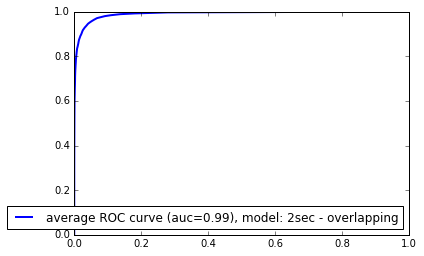

In [17]:
data2 = read_data('all') 
feats, y = get_features2(data2, 2)
X_train, X_test, y_train, y_test = train_test_split(feats, y, test_size=.25,
                                                    random_state=0, stratify=y)
best_model.fit(X_train, y_train)
eval_model(best_model, X_test, y_test,'2sec - overlapping')
